## WHO GHO Indicators for Obesity Research

**Analysis of 3,039 available WHO indicators found 808 obesity-related indicators:**

| Category | Count | Key Examples |
|----------|-------|--------------|
| **Direct Obesity/BMI** | 29 | `NCD_BMI_30A` (adult obesity), `NCD_BMI_25C` (overweight), child malnutrition |
| **Physical Activity** | 17 | `NCD_PAC` (insufficient activity), PA guidelines, workplace initiatives |
| **Nutrition/Diet** | 76 | Minimum acceptable diet, food safety, unhealthy diet policies |
| **Diabetes/Glucose** | 22 | `NCD_GLUC_04` (raised blood glucose), diabetes testing, HbA1c |
| **Cardiovascular** | 27 | `BP_04` (hypertension), blood pressure, heart disease mortality |
| **Tobacco** | 248 | Tobacco use, advertising bans, tobacco control programs |
| **Alcohol** | 275 | Alcohol consumption, use disorders, BAC limits |
| **Socioeconomic** | 84 | Poverty (`CCO_1`), literacy, income inequality |
| **Geographic** | 27 | Urban/rural population, city coverage |
| **Healthcare** | 62 | Health expenditure, financial protection, access |

**Full list saved to:** `data/who_indicators_obesity_related.csv`



In [99]:
# Setup for Google Colab
# Uncomment and edit the lines below if running in Colab:

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/Obesity')  # Change this to your path


# Obesity — Data Collection

Download WHO Global Health Observatory indicator data, merge into a single CSV file.

**Quick Start:** Change `query` below to select indicators (e.g., `'obesity'`, `'tobacco'`, `'diabetes'`), then run all cells.

## Configuration & Setup

In [100]:
import requests
import pandas as pd
import time

query = 'NCD_BMI|obesity|overweight|physical activity|diabetes|glucose|hypertension|blood pressure|tobacco|income|poverty|education'

print(f'Query: {query}')

Query: NCD_BMI|obesity|overweight|physical activity|diabetes|glucose|hypertension|blood pressure|tobacco|income|poverty|education


## Load Existing Indicators Based On Query

In [101]:
import pandas as pd
import requests
import time
from glob import glob
import numpy as np
import os

indicators_df = pd.read_csv('../data/who_indicators_all.csv')[['IndicatorCode', 'IndicatorName']].drop_duplicates()

# Load existing data
data_file = '../data/who_obesity_data.csv'
df = pd.read_csv(data_file)
print(f'Loaded existing data: {len(df):,} rows')

existing_codes = set(df['IndicatorCode'].unique())
print(f'Existing: {len(existing_codes)} indicators, {len(df):,} rows')

# Filter by query

query_mask = (indicators_df['IndicatorName'].str.contains(query, case=False, na=False) | 
              indicators_df['IndicatorCode'].str.contains(query, case=False, na=False))

# Exclude existing indicators
new_df = indicators_df[query_mask][~indicators_df['IndicatorCode'].isin(existing_codes)]

selected_indicators = new_df.to_dict('records')

print(f'New Indicators to Download: {len(selected_indicators)}')


C:\Users\Jack\AppData\Local\Temp\ipykernel_34536\2390724579.py:12: DtypeWarning: Columns (0,1,2,4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


Loaded existing data: 1,985,207 rows
Existing: 480 indicators, 1,985,207 rows
New Indicators to Download: 0


C:\Users\Jack\AppData\Local\Temp\ipykernel_34536\2390724579.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_df = indicators_df[query_mask][~indicators_df['IndicatorCode'].isin(existing_codes)]


## Download Indicator Data

In [102]:
# Download indicator data
if len(selected_indicators) > 0:
    new_rows = []  # Collect new rows

    for idx, indicator in enumerate(selected_indicators, 1):
        code = indicator.get("IndicatorCode")
        name = indicator.get("IndicatorName", "")
        print(f"[{idx}/{len(selected_indicators)}] {code}...", end=" ")
    
        try:
            r = requests.get(f"https://ghoapi.azureedge.net/api/{code}", timeout=30)
            if r.status_code == 200:
                records = r.json().get("value", [])
            
                if len(records) == 0:
                    # Add dummy row with indicator info, other columns will be NA
                    dummy_row = {"IndicatorCode": code, "IndicatorName": name}
                    new_rows.append(dummy_row)
                    print(f"no data (added NA row)")
                else:
                    for rec in records:
                        rec["IndicatorCode"] = code
                        rec["IndicatorName"] = name
                    new_rows.extend(records)
                    print(f"OK {len(records)} records")
            else:
                print(f"Error {r.status_code}")
        except Exception as e:
            print(f"Error: {e}")
        time.sleep(0.2)
    
    # Append new rows to df
    if len(new_rows) > 0:
        downloaded_df = pd.DataFrame(new_rows)
        df = pd.concat([df, downloaded_df], ignore_index=True)
        print(f"\nAdded {len(new_rows):,} rows, {downloaded_df['IndicatorCode'].nunique()} indicators")
else:
    print("Skipping download - no new indicators to fetch")


Skipping download - no new indicators to fetch


## Save to CSV

In [103]:
# Save data
if len(selected_indicators) > 0:
    import os
    
    print("Saving dataset...")
    
    # Save to single file (Git LFS handles the large size)
    output_file = "../data/who_obesity_data.csv"
    df.to_csv(output_file, index=False)
    
    file_size_mb = os.path.getsize(output_file) / 1024 / 1024
    
    print("\nSaved successfully!")
    print("  File: who_obesity_data.csv")
    print(f"  Size: {file_size_mb:.2f} MB")
    print(f"  Total rows: {len(df):,}")
    print(f"  Total indicators: {df['IndicatorCode'].nunique()}")
else:
    print("No new data to save")


No new data to save


## View Results

In [104]:
# Dataset Overview Dashboard
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

print('=' * 80)
print('DATASET OVERVIEW'.center(80))
print('=' * 80)

# Basic statistics
total_rows = len(df)
total_indicators = df['IndicatorCode'].nunique()


print(f'\n📈 Data Summary:')
print(f'  Total Records: {total_rows:,}')
print(f'  Unique Indicators: {total_indicators}')
print(f'  Countries/Regions: {total_countries}')
print(f'  Year Range: {year_range}')
print(f'  Columns: {df.shape[1]}')


# Temporal coverage
print(f'\n📅 Temporal Distribution:')
year_counts = df['TimeDim'].value_counts().sort_index()
print(f'  Most data from: {year_counts.idxmax()} ({year_counts.max():,} records)')
print(f'  Years with data: {len(year_counts)}')

print('\n' + '=' * 80)

                                DATASET OVERVIEW                                



📈 Data Summary:
  Total Records: 1,985,207
  Unique Indicators: 480
  Countries/Regions: 341
  Year Range: 1974.0 - 2030.0
  Columns: 28

📅 Temporal Distribution:
  Most data from: 2014.0 (107,211 records)
  Years with data: 53



## Data Coverage Graph

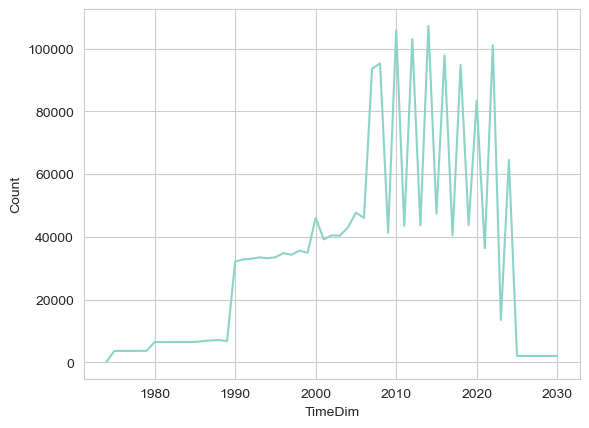

In [122]:
# Data Coverage Over Time
import seaborn as sns
import matplotlib.pyplot as plt

year_dist = df.groupby('TimeDim').size().reset_index(name='Count')

sns.lineplot(data=year_dist, x='TimeDim', y='Count')
plt.show()

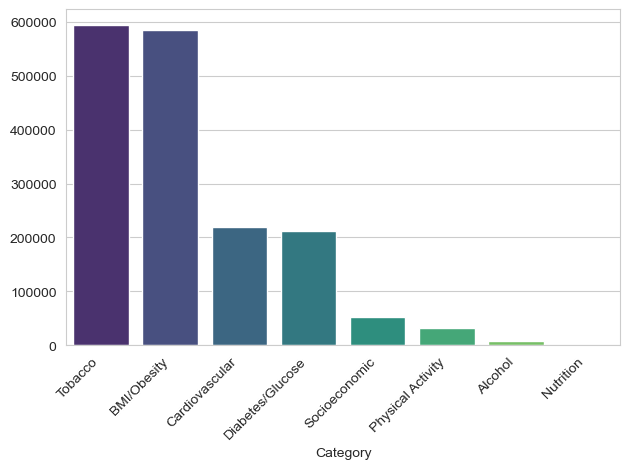

In [123]:
# Indicator Category Distribution
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load categorized indicators
indicators_cat = pd.read_csv('../data/who_indicators_obesity_related.csv')[['IndicatorCode', 'Category']]

# Join on IndicatorCode
df_with_cat = df.join(indicators_cat.set_index('IndicatorCode'), on='IndicatorCode', how='left')

# Count records by category
cat_counts = df_with_cat['Category'].value_counts()

# Plot
sns.barplot(x=cat_counts.index, y=cat_counts.values, hue=cat_counts.index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\Jack\AppData\Local\Temp\ipykernel_34536\1194035103.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


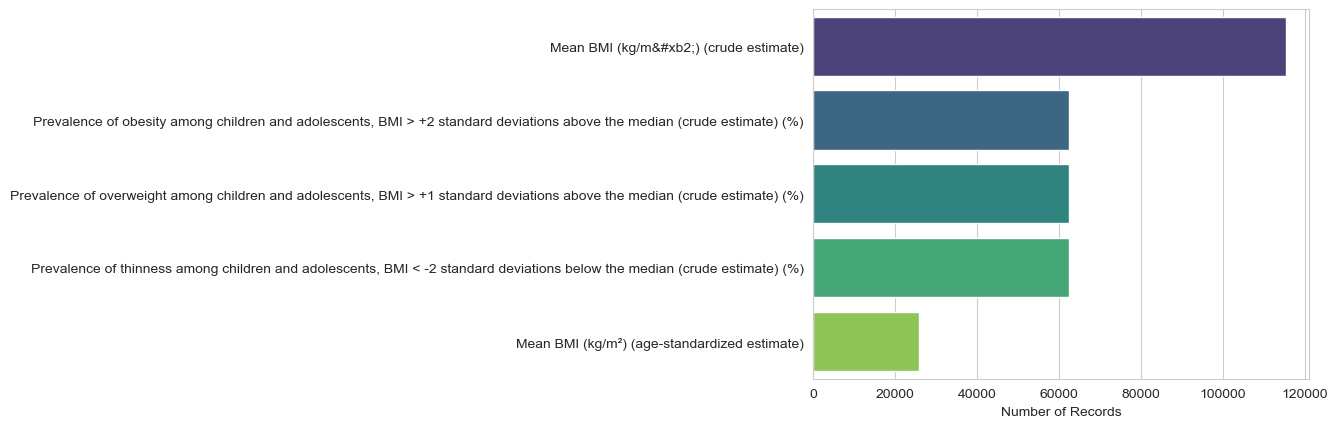


Top 5 BMI indicators
Total records shown: 328,337


In [ ]:
# BMI Indicators Available (Top 5)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Filter for BMI indicators only
bmi_data = df[df['IndicatorCode'].str.contains('BMI', case=False, na=False)]

# Count records by indicator and get names
bmi_indicators = bmi_data.groupby(['IndicatorCode', 'IndicatorName']).size().reset_index(name='Count')

# Get top 5 by count
bmi_indicators = bmi_indicators.sort_values('Count', ascending=False).head(5)

# Horizontal barplot
sns.barplot(data=bmi_indicators, y='IndicatorName', x='Count', hue='IndicatorName', palette='viridis', legend=False)
plt.xlabel('Number of Records')
plt.ylabel('')
plt.show()

print(f'\nTop 5 BMI indicators')
print(f'Total records shown: {bmi_indicators["Count"].sum():,}')

In [ ]:
# Define WHO core indicator categories
core_indicators = {
    'Direct Obesity Measures': [
        'NCD_BMI_30A',      # Adult obesity (BMI ≥ 30)
        'NCD_BMI_25A',      # Adult overweight (BMI ≥ 25)
        'NCD_BMI_30C',      # Child/adolescent obesity
        'NCD_BMI_PLUS2C',   # Child overweight
    ],
    'Risk Factors': [
        'NCD_PAC_01',       # Insufficient physical activity
        'NCD_GLUC_04',      # Raised blood glucose (diabetes)
        'BP_04',            # Raised blood pressure (hypertension)
        'NCD_CCS_01',       # Raised cholesterol
    ],
    'Socioeconomic Determinants': [
        'WHS9_86',          # Literacy rate
        'WHS4_117',         # Education expenditure
        'WHS8_110',         # Urban population percentage
        'POVERTY_PERC1',    # Population below poverty line
        'GHED_CHE_PC_PPP',  # Health expenditure per capita
        'NY.GDP.PCAP.PP.CD', # GDP per capita (PPP, current international $)
        'SI.POV.GINI',      # GINI index (income inequality)
        'WHOSIS_000002',    # GNI per capita
    ],
    'Behavioral Risk Factors': [
        'SA_0000001400',    # Alcohol consumption per capita
        'M_Est_smk_curr',   # Current tobacco smoking
        'NCD_SALT_INTAKE',  # Mean salt/sodium intake
    ]
}

# Flatten to get all core indicator codes
all_core_codes = [code for codes in core_indicators.values() for code in codes]
print(f'Defined {len(all_core_codes)} core indicators across {len(core_indicators)} categories')

In [127]:
# Summary Report Card
print('\n' + '=' * 80)
print('DATASET SUMMARY REPORT'.center(80))
print('=' * 80)

# Key metrics
print(f'\nKEY METRICS:')
print(f'  ├─ Total Records: {len(df):,}')
print(f'  ├─ Unique Indicators: {df["IndicatorCode"].nunique()}')
print(f'  ├─ Countries/Regions: {df["SpatialDim"].nunique()}')
print(f'  ├─ Time Span: {df["TimeDim"].min()} to {df["TimeDim"].max()} ({df["TimeDim"].max() - df["TimeDim"].min()} years)')
print(f'  └─ Average Records per Indicator: {len(df) / df["IndicatorCode"].nunique():.0f}')


# Data Coverage
print(f'\nData Coverage:')
recent_years = df[df['TimeDim'] >= 2020]['TimeDim'].value_counts().sort_index()
print(f'  Recent data (2020+): {recent_years.sum():,} records across {len(recent_years)} years')
print(f'  Most recent year with data: {df["TimeDim"].max()}')
print(f'  Years with most data: {df["TimeDim"].value_counts().head(5).to_dict()}')




                             DATASET SUMMARY REPORT                             

KEY METRICS:
  ├─ Total Records: 1,985,207
  ├─ Unique Indicators: 480
  ├─ Countries/Regions: 341
  ├─ Time Span: 1974.0 to 2030.0 (56.0 years)
  └─ Average Records per Indicator: 4136

Data Coverage:
  Recent data (2020+): 302,826 records across 7 years
  Most recent year with data: 2030.0
  Years with most data: {2014.0: 107211, 2010.0: 105803, 2012.0: 102982, 2022.0: 101055, 2016.0: 97761}
